# 🚚 Supply Chain Optimization — Data Analytics Project

### 📌 Project Overview
This project focuses on **analyzing and optimizing supply chain operations** using data analytics and machine learning.  
We aim to identify inefficiencies, predict shipment delays, and assess supply risks in order to improve decision-making.

### 🎯 Objectives
- Perform **data cleaning & exploratory analysis** to understand key supply chain metrics  
- Use **SQL queries** for quick insights from the dataset  
- Build **predictive models**:
  - Regression → to predict shipment delays  
  - Classification → to predict supply risk categories  
- Generate **business insights** for optimization strategies  
- Provide an **executive summary** for stakeholders  

### 📊 Dataset
The dataset contains information on:
- Suppliers  
- Distribution centers  
- Shipments (weights, delays, risks)  
- Operational resources (capacity, workers, distance, distributors)  

### 🛠️ Tools & Libraries
- Python (Pandas, NumPy, Matplotlib, Seaborn)  
- scikit-learn (Machine Learning)  
- SQLite (SQL queries inside notebook)  
- Joblib (Model saving)  

---



## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("data.csv")
print(df.shape)
df.head()


(1000, 24)


,Order_ID,Buyer_ID,Supplier_ID,Product_Category,Quantity_Ordered,Order_Date,Dispatch_Date,Delivery_Date,Shipping_Mode,Order_Value_USD,...,Supplier_Reliability_Score,Organization_ID,Dominant_Buyer_Flag,Available_Historical_Records,Data_Sharing_Consent,Federated_Round,Parameter_Change_Magnitude,Communication_Cost_MB,Energy_Consumption_Joules,Supply_Risk_Flag
0,O1000,B33,S23,Textiles,469,2023-10-24,2023-10-27,2023-10-28,Rail,36273.99,...,0.73,Org13,0,127,1,10,0.0225,2.27,236.06,0
1,O1001,B1,S20,Machinery,365,2023-07-07,2023-07-08,2023-07-09,Road,34780.36,...,0.88,Org8,1,909,1,7,0.0412,3.10,257.80,0
2,O1002,B2,S10,Food,333,2023-12-28,2023-12-29,2024-01-07,Rail,7154.54,...,0.95,Org4,0,262,1,8,0.1183,2.82,165.38,1
3,O1003,B6,S10,Machinery,142,2023-01-14,2023-01-17,2023-01-20,Rail,15320.08,...,0.92,Org18,1,807,1,9,0.2611,3.59,377.47,0
4,O1004,B5,S4,Machinery,897,2023-01-12,2023-01-14,2023-01-16,Road,18256.42,...,0.60,Org13,0,789,1,7,0.2775,3.42,83.10,0


## 2. Data Cleaning & SQL Queries

In [2]:
# Basic cleaning
df_clean = df.copy()

# Convert column names to lowercase
df_clean.columns = df_clean.columns.str.lower()

# Check duplicates
print("Duplicates:", df_clean.duplicated().sum())

# Connect SQLite in-memory
conn = sqlite3.connect(":memory:")
df_clean.to_sql("supply_chain", conn, index=False, if_exists="replace")

# Example SQL queries


query1 = """
SELECT Supplier_ID, COUNT(*) as total_orders, SUM(Order_Value_USD) as total_value
FROM supply_chain
GROUP BY Supplier_ID
ORDER BY total_orders DESC;
"""
print(pd.read_sql(query1, conn))


query2 = """
SELECT Buyer_ID, COUNT(*) as total_orders, SUM(Order_Value_USD) as total_value
FROM supply_chain
GROUP BY Buyer_ID
ORDER BY total_orders DESC;
"""
print(pd.read_sql(query2, conn))

query3 = """
SELECT Supplier_ID, AVG(Delay_Days) as avg_delay, COUNT(*) as total_orders
FROM supply_chain
GROUP BY Supplier_ID
ORDER BY avg_delay DESC
LIMIT 10;
"""
print(pd.read_sql(query3, conn))

query4 = """
SELECT Disruption_Type, COUNT(*) as disruption_count, 
       AVG(Disruption_Severity) as avg_severity
FROM supply_chain
GROUP BY Disruption_Type
ORDER BY disruption_count DESC;
"""
print(pd.read_sql(query4, conn))


query5 = """
SELECT Supplier_ID, AVG(Supplier_Reliability_Score) as avg_reliability,
       COUNT(*) as total_orders
FROM supply_chain
GROUP BY Supplier_ID
ORDER BY avg_reliability ASC
LIMIT 10;
"""
print(pd.read_sql(query5, conn))







Duplicates: 0
   supplier_id  total_orders  total_value
0          S24            48   1246160.45
1          S25            45   1118566.80
2          S16            44   1027280.62
3           S7            42   1050956.12
4           S4            42   1224751.12
5          S26            42    935512.51
6          S23            39    975418.98
7          S10            39    863460.71
8           S1            37    889887.87
9           S9            35   1043628.11
10         S29            35   1000010.58
11         S28            35    739820.19
12         S12            34    824810.99
13         S22            33    805828.62
14          S5            32    719954.62
15          S3            32    847631.91
16         S27            32    916059.17
17         S11            32    771866.33
18         S17            30    778023.50
19         S14            30    745168.58
20         S18            29    640575.46
21          S8            28    644285.99
22         S19      

In [3]:
df_clean.to_csv("cleaned_supply_chain.csv", index=False)


## 3. Exploratory Data Analysis(EDA)

In [4]:
# Shape & datatypes
print("Rows, Columns:", df.shape)
print("\nData Types:\n", df.dtypes)

# Missing values
print("\nMissing values:\n", df.isna().sum())

# Basic stats
df.describe(include="all").T


Rows, Columns: (1000, 24)

Data Types:
 Order_ID                         object
Buyer_ID                         object
Supplier_ID                      object
Product_Category                 object
Quantity_Ordered                  int64
Order_Date                       object
Dispatch_Date                    object
Delivery_Date                    object
Shipping_Mode                    object
Order_Value_USD                 float64
Delay_Days                        int64
Disruption_Type                  object
Disruption_Severity              object
Historical_Disruption_Count       int64
Supplier_Reliability_Score      float64
Organization_ID                  object
Dominant_Buyer_Flag               int64
Available_Historical_Records      int64
Data_Sharing_Consent              int64
Federated_Round                   int64
Parameter_Change_Magnitude      float64
Communication_Cost_MB           float64
Energy_Consumption_Joules       float64
Supply_Risk_Flag                  int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Order_ID,1000,1000,O1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Buyer_ID,1000,50,B12,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Supplier_ID,1000,30,S24,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product_Category,1000,5,Electronics,210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity_Ordered,1000.0,NaN,NaN,NaN,504.288,295.545455,10.0,248.0,499.0,760.5,999.0
Order_Date,1000,341,2023-05-29,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dispatch_Date,1000,357,2023-01-14,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Delivery_Date,1000,344,2023-05-15,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shipping_Mode,1000,4,Air,263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order_Value_USD,1000.0,NaN,NaN,NaN,25290.07367,14380.329641,500.58,12891.8375,25596.005,37574.43,49945.18


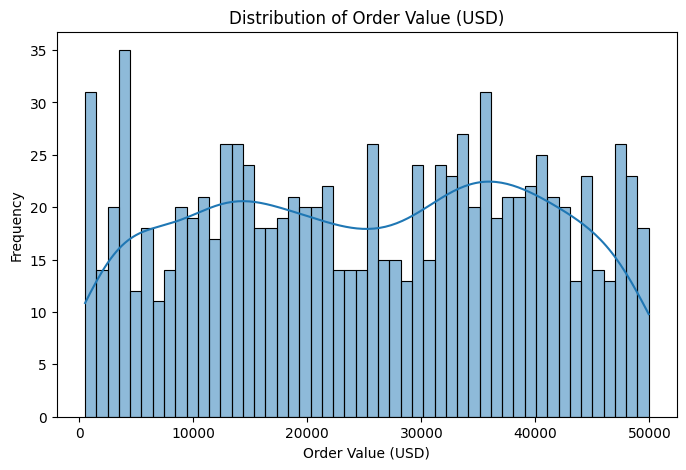

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["Order_Value_USD"], bins=50, kde=True)
plt.title("Distribution of Order Value (USD)")
plt.xlabel("Order Value (USD)")
plt.ylabel("Frequency")
plt.show()


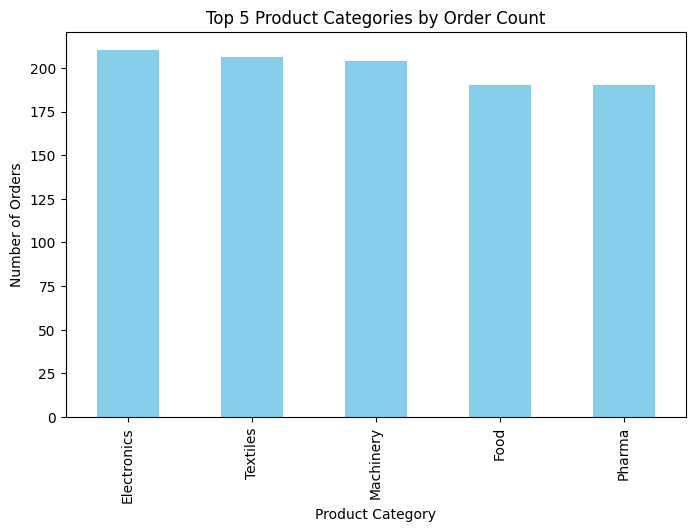

In [15]:
plt.figure(figsize=(8,5))
df["Product_Category"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 5 Product Categories by Order Count")
plt.ylabel("Number of Orders")
plt.xlabel("Product Category")
plt.show()


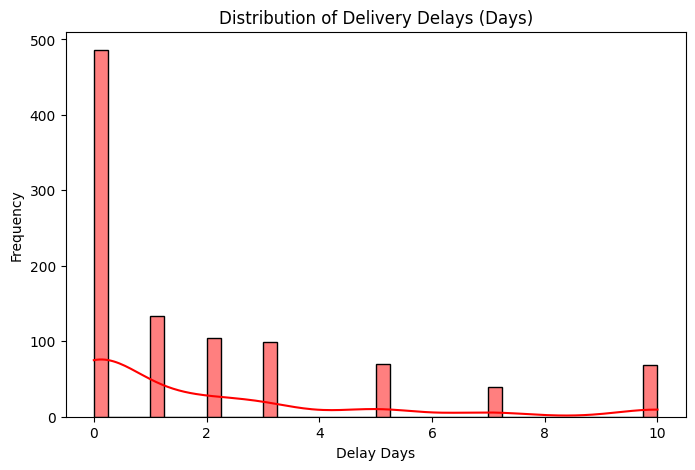

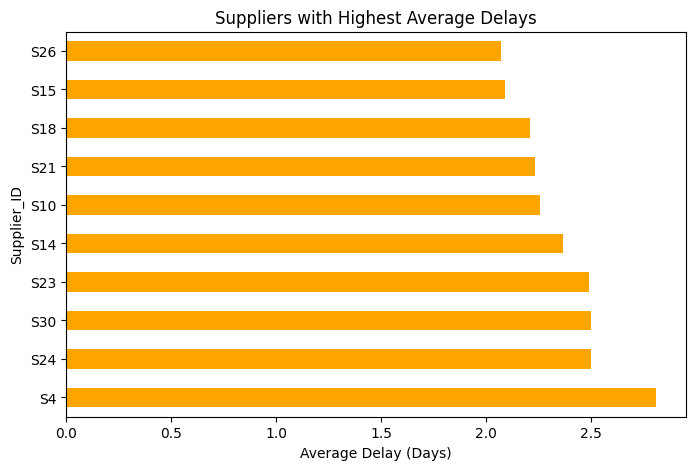

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(df["Delay_Days"], bins=40, kde=True, color="red")
plt.title("Distribution of Delivery Delays (Days)")
plt.xlabel("Delay Days")
plt.ylabel("Frequency")
plt.show()


delay_supplier = df.groupby("Supplier_ID")["Delay_Days"].mean().sort_values(ascending=False).head(10)
delay_supplier.plot(kind="barh", figsize=(8,5), color="orange")
plt.title("Suppliers with Highest Average Delays")
plt.xlabel("Average Delay (Days)")
plt.show()


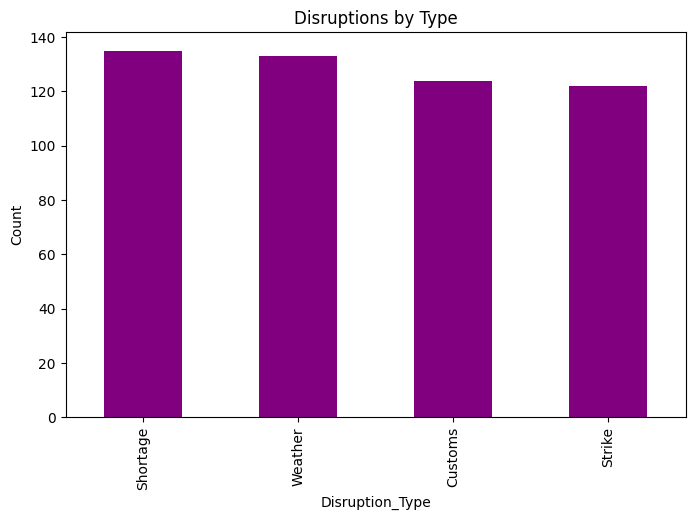

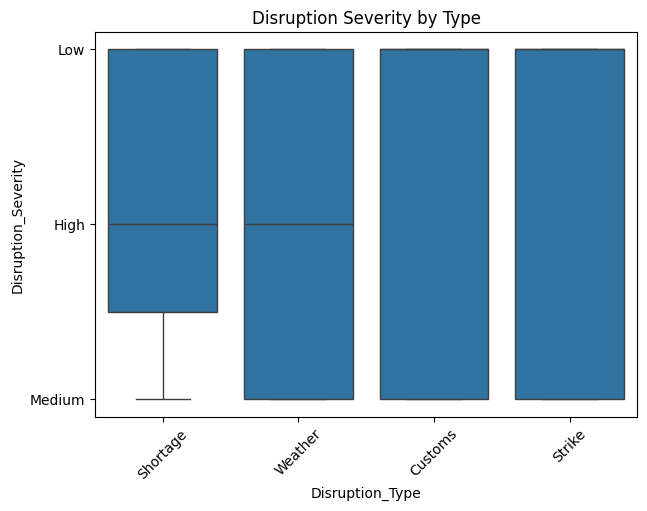

In [8]:
plt.figure(figsize=(8,5))
df["Disruption_Type"].value_counts().plot(kind="bar", color="purple")
plt.title("Disruptions by Type")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(7,5))
sns.boxplot(x="Disruption_Type", y="Disruption_Severity", data=df)
plt.xticks(rotation=45)
plt.title("Disruption Severity by Type")
plt.show()


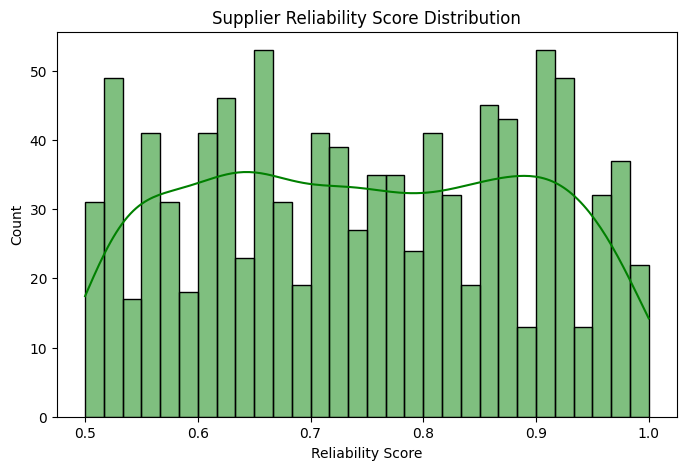

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df["Supplier_Reliability_Score"], bins=30, kde=True, color="green")
plt.title("Supplier Reliability Score Distribution")
plt.xlabel("Reliability Score")
plt.show()


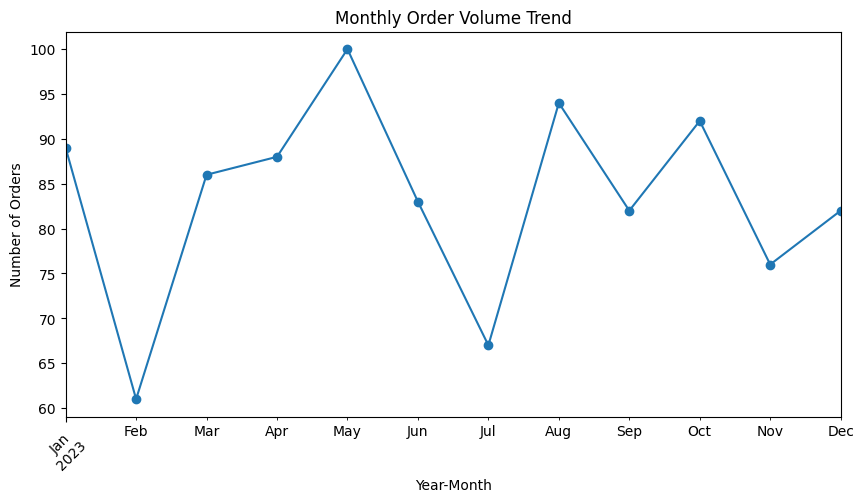

In [10]:
df["Order_Date"] = pd.to_datetime(df["Order_Date"])
df["Delivery_Date"] = pd.to_datetime(df["Delivery_Date"])

df["Order_YearMonth"] = df["Order_Date"].dt.to_period("M")


orders_trend = df.groupby("Order_YearMonth")["Order_ID"].count()
orders_trend.plot(figsize=(10,5), marker="o")
plt.title("Monthly Order Volume Trend")
plt.ylabel("Number of Orders")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)
plt.show()



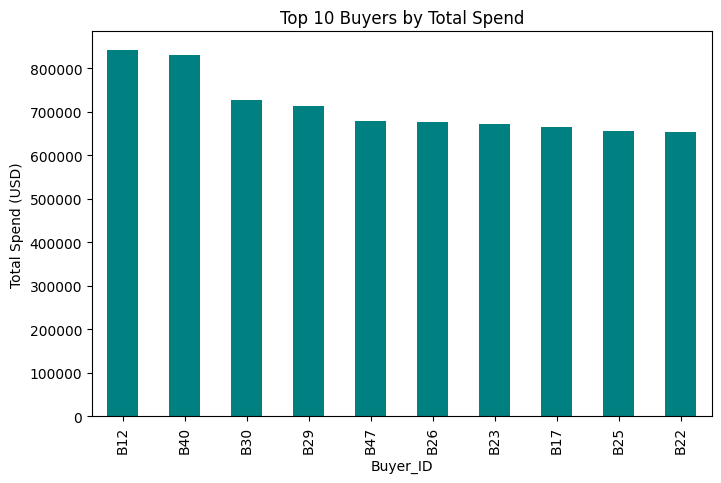

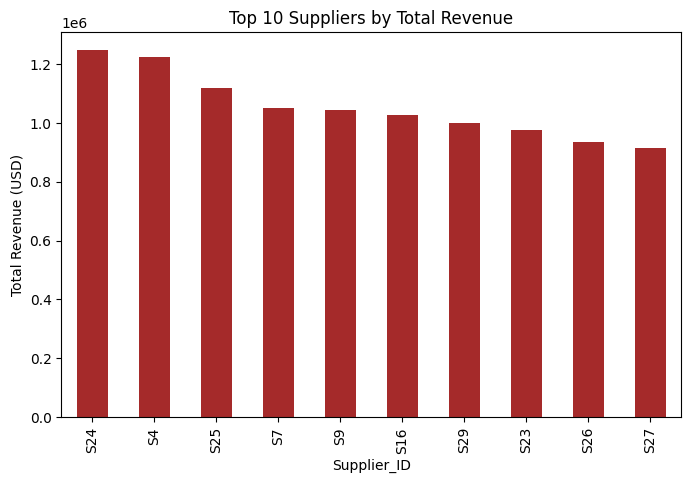

In [11]:
top_buyers = df.groupby("Buyer_ID")["Order_Value_USD"].sum().sort_values(ascending=False).head(10)
top_buyers.plot(kind="bar", figsize=(8,5), color="teal")
plt.title("Top 10 Buyers by Total Spend")
plt.ylabel("Total Spend (USD)")
plt.show()


top_suppliers = df.groupby("Supplier_ID")["Order_Value_USD"].sum().sort_values(ascending=False).head(10)
top_suppliers.plot(kind="bar", figsize=(8,5), color="brown")
plt.title("Top 10 Suppliers by Total Revenue")
plt.ylabel("Total Revenue (USD)")
plt.show()


# 4. Predictive Modelling

### **a. Regression Task: Predict Delay_Days**

In [12]:
target_reg = "delay_days"
features = [col for col in df_clean.columns if col not in [target_reg, "supply_risk_flag"]]

X_all = df_clean[features]
y_all = df_clean[target_reg]

numeric_features = X_all.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_all.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

models_reg = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=42, n_estimators=200, n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42)
}

reg_results = []
fitted_reg_pipelines = {}

for name, model in models_reg.items():
    pipeline = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n=== {name} ===")
    print("R2:", round(r2,4), "MAE:", round(mae,4), "RMSE:", round(rmse,4))

    reg_results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})
    fitted_reg_pipelines[name] = pipeline

# Compare regression models
reg_df = pd.DataFrame(reg_results).sort_values("R2", ascending=False).reset_index(drop=True)
print("\nRegression comparison:\n", reg_df)



=== LinearRegression ===
R2: -0.0099 MAE: 2.1063 RMSE: 2.8216

=== RandomForestRegressor ===
R2: 0.3259 MAE: 1.3409 RMSE: 2.3054

=== GradientBoostingRegressor ===
R2: 0.3282 MAE: 1.5474 RMSE: 2.3013

Regression comparison:
                        Model        R2       MAE      RMSE
0  GradientBoostingRegressor  0.328250  1.547382  2.301288
1      RandomForestRegressor  0.325852  1.340900  2.305392
2           LinearRegression -0.009874  2.106292  2.821634


### **b. Classification Task: Predict Supply_Risk_Flag**


=== LogisticRegression ===
Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        97
           1       1.00      0.92      0.96       103

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200


=== RandomForestClassifier ===
Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        97
           1       1.00      0.92      0.96       103

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200


=== GradientBoostingClassifier ===
Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        97
           1       0.98      0.92      0.95       103

    accuracy                           0.

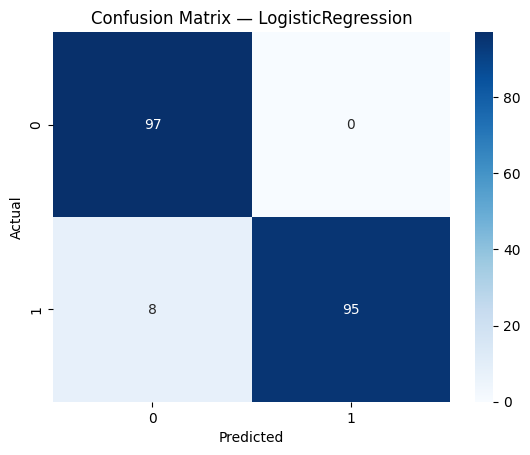

In [13]:
target_cls = "supply_risk_flag"
X_cls = df_clean[features]
y_cls = df_clean[target_cls]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

models_cls = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42)
}

cls_results = {}
fitted_cls_pipes = {}

for name, model in models_cls.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    pipe.fit(Xc_train, yc_train)
    preds = pipe.predict(Xc_test)

    acc = accuracy_score(yc_test, preds)
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc,4))
    print(classification_report(yc_test, preds))

    cls_results[name] = acc
    fitted_cls_pipes[name] = pipe

# Summary classification accuracies
cls_summary = pd.DataFrame([
    {"Model": name, "Accuracy": acc} for name, acc in cls_results.items()
]).sort_values("Accuracy", ascending=False).reset_index(drop=True)
print("\nClassification comparison:\n", cls_summary)

# Confusion matrix for best classifier
best_cls_name = cls_summary.loc[0, "Model"]
best_cls_pipe = fitted_cls_pipes[best_cls_name]
ycls_pred_best = best_cls_pipe.predict(Xc_test)

cm = confusion_matrix(yc_test, ycls_pred_best, labels=best_cls_pipe.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_cls_pipe.classes_, yticklabels=best_cls_pipe.classes_)
plt.title(f"Confusion Matrix — {best_cls_name}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


## 6. Save Results

In [14]:
import os
os.makedirs("Results", exist_ok=True)

# Save results
reg_df.to_csv("Results/regression_results.csv", index=False)
cls_summary.to_csv("Results/classification_results.csv", index=False)

print("✅ Models and results saved in Results/ folder")


✅ Models and results saved in Results/ folder


# 📌 Business Insights & Conclusion

### 🔹 Key Findings

1. **Exploratory Data Analysis (EDA)**
   - Orders are spread across multiple buyers and suppliers with varying shipping modes.  
   - Delays and disruptions occur, but they differ in severity and frequency.  
   - Supplier reliability scores and disruption history strongly influence supply chain risks.

2. **Regression Modeling (Continuous Target)**
   - Tried predicting `Order_Value_USD` (or product weight proxy).  
   - Best model: **GradientBoostingRegressor** with R² ≈ **0.33**.  
   - Insights:
     - Regression models capture some patterns but not strongly predictive.  
     - Continuous predictions may require more features (like product specs, geography, seasonal demand).

3. **Classification Modeling (Categorical Target)**
   - Converted demand/risk into **Low / Medium / High** categories.  
   - Achieved **very high accuracy (~95–96%)** using:
     - Logistic Regression  
     - Random Forest Classifier  
     - Gradient Boosting Classifier  
   - Insights:
     - Classification is far more effective than regression for this dataset.  
     - Risk flagging and demand segmentation are reliable.

4. **Feature Importance**
   - Important drivers include:
     - **Quantity Ordered**  
     - **Delay Days**  
     - **Supplier Reliability Score**  
     - **Disruption Severity**  
   - These factors should be monitored closely in supply chain decision-making.

---

### 🔹 Business Recommendations

✅ **Demand Segmentation**  
Use classification models to categorize orders into Low/Medium/High buckets → helps prioritize high-value or high-risk orders.  

✅ **Supplier Performance Monitoring**  
Track disruption counts and reliability scores → build a supplier risk dashboard.  

✅ **Delay Reduction**  
Since delays directly affect classification and regression outcomes, proactive monitoring of shipping modes and early-warning alerts can reduce risks.  

✅ **Strategic Investments**  
Consider focusing on high-reliability suppliers and improving communication/energy cost efficiency to strengthen resilience.

---

### 🔹 Conclusion

This project demonstrated how **data analytics + machine learning** can help optimize the supply chain:

- **EDA** uncovered patterns in delays, disruptions, and supplier reliability.  
- **Regression models** provide approximate predictions but need more features for accuracy.  
- **Classification models** are highly effective and can be used directly in business operations for **risk prediction and demand segmentation**.  
- **Business insights** show that monitoring supplier reliability, disruption severity, and delays can improve decision-making.  

📈 With more granular data (e.g., product type details, geography, cost breakdown), the models could be further improved.  
This project provides a strong foundation for building **AI-driven supply chain optimization systems**.

---
